**Install tensorflow**

In [37]:
%pip install --user ipykernel

In [38]:
%pip install --user tensorflow==2.18.0

Note: you may need to restart the kernel to use updated packages.


### Import tensorflow, keras modules

In [39]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from scipy.special import softmax
from tensorflow.keras import datasets, layers, models


print(tf.__version__)
print(tf.keras.__version__)

2.18.0
3.6.0


### Import CIFAR-10 Dataset automatically

TensorFlow Datasets: https://www.tensorflow.org/api_docs/python/tf/keras/datasets\
Dataset explanations https://keras.io/datasets/

In [40]:
data_set = tf.keras.datasets.cifar10

Encode, Normalize and Split data

In [41]:
# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = data_set.load_data()

# Normalize input between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0


In [42]:
# Check shapes of train_images, train_labels etc
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)


### Visualize the dataset

In [55]:
# For printing, we name each of the 10 classes below
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

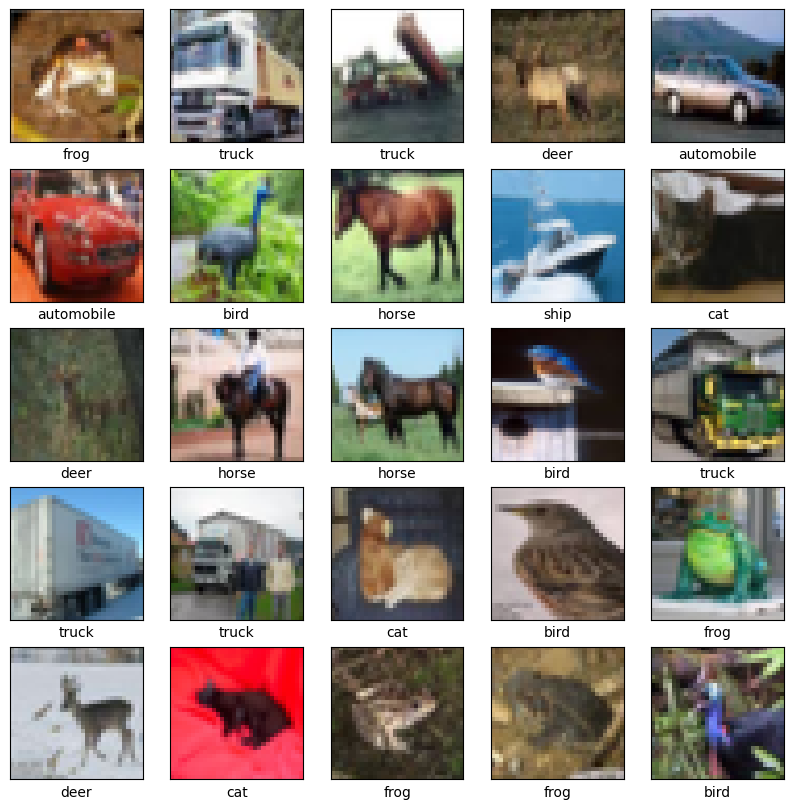

In [56]:

plt.figure(figsize=(10, 10))

train_labels_arr = np.array(train_labels)
train_images_arr = np.array(train_images)

for i in range(25):  
    plt.subplot(5, 5, i + 1)
    plt.xticks([])  # Hide x ticks
    plt.yticks([])  # Hide y ticks
    plt.grid(False)  # Turn off grid
    plt.imshow(train_images_arr[i]) 
    plt.xlabel(class_names[train_labels_arr[i][0]])  # Label with class name from label (not index)
    
plt.show()

**Multi-class Logistic Regression Model**

In [57]:
class MultiClassLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=500, batch_size=32, reg_lambda=0.01):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_lambda = reg_lambda
        self.errors = []
        self.weights = None
        self.bias = None
        # Initialize Keras loss function
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()

    def softmax(self, z):
        shifted_logits = z - np.max(z, axis=1, keepdims=True)
        exp_scores = np.exp(shifted_logits)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        return self.loss_fn(y_true, y_pred).numpy()

    def train(self, X, y):
        # Reshape the input data 

        X = X.reshape(X.shape[0], -1)
        m, n = X.shape
        # Conver labels to one-hot encoding 
        y = tf.keras.utils.to_categorical(y, num_classes=10)
        
        # Initialize weights 
        self.weights = np.random.randn(n, y.shape[1]) * np.sqrt(2.0 / n)
        self.bias = np.zeros((1, y.shape[1]))
        
        initial_lr = self.learning_rate

        for epoch in range(self.epochs):
            # Use a lerning rate schedule to speed up convergence
            self.learning_rate = initial_lr / (1 + epoch * 0.01)
            
            # Shuffle the data randomly
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Use mini batch training (batch size 32)
            for i in range(0, m, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                
                # Forward pass
                logits = np.dot(X_batch, self.weights) + self.bias
                y_pred = self.softmax(logits)
                
                # Backward pass with L2 regularization to reduce overfitting
                grad_logits = y_pred - y_batch
                grad_weights = (np.dot(X_batch.T, grad_logits) / self.batch_size + 
                              self.reg_lambda * self.weights)
                grad_bias = np.mean(grad_logits, axis=0, keepdims=True)
                
                # Update weights and bias
                self.weights -= self.learning_rate * grad_weights
                self.bias -= self.learning_rate * grad_bias

            # Compute training error
            y_pred = self.softmax(np.dot(X, self.weights) + self.bias)
            train_error = self.compute_loss(y, y_pred)
            self.errors.append(train_error)
            
            # Print out progress every 50 epochs
            if epoch % 50 == 0:
                train_acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
                print(f"Epoch {epoch} - Loss: {train_error:.4f}, Accuracy: {train_acc:.4f}")

    def predict(self, X):
        if len(X.shape) > 2:
            X = X.reshape(X.shape[0], -1)
        logits = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(logits)
        return np.argmax(y_pred, axis=1)

Starting training...
Epoch 0 - Loss: 7.6695, Accuracy: 0.2438
Epoch 50 - Loss: 4.5476, Accuracy: 0.2716
Epoch 100 - Loss: 5.8805, Accuracy: 0.2004
Epoch 150 - Loss: 3.7526, Accuracy: 0.2575
Epoch 200 - Loss: 2.3991, Accuracy: 0.2833
Epoch 250 - Loss: 2.1453, Accuracy: 0.3265

Test accuracy: 27.10%


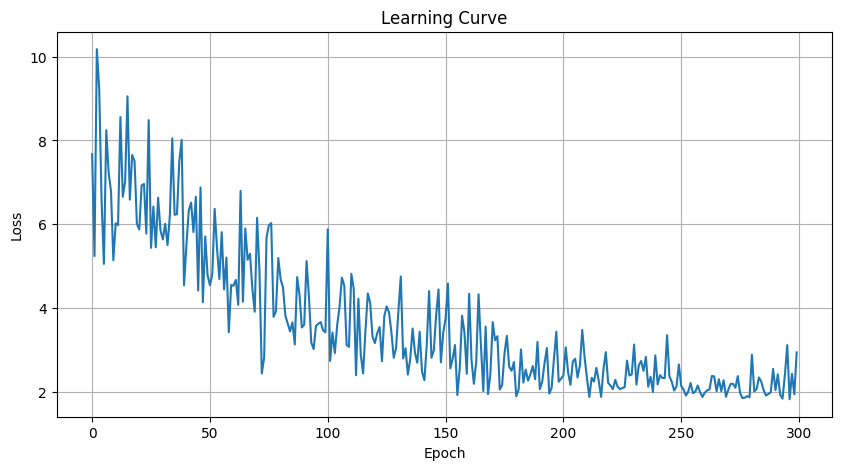

In [58]:
# Initialize model
model = MultiClassLogisticRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=32,
    reg_lambda=0.01
)

# Train
print("Starting training...")
model.train(train_images, train_labels)

# Evaluate
predictions = model.predict(test_images)
accuracy = np.mean(predictions == test_labels.ravel())
print(f"\nTest accuracy: {accuracy * 100:.2f}%")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(model.errors)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.grid(True)
plt.show()

An overall ~5% improvement in test accuracy was achieved by incorporating methods such as mini batch training, L2 regularization, and a learning rate scheduler. Overall test accuracy is almost 27.10%. Despite attempts to improve this result it is clear that multi-class logistic regression is not performant on image data. Regardless, exploring different tecniques to manipulate and improve the results was a useful excercise.

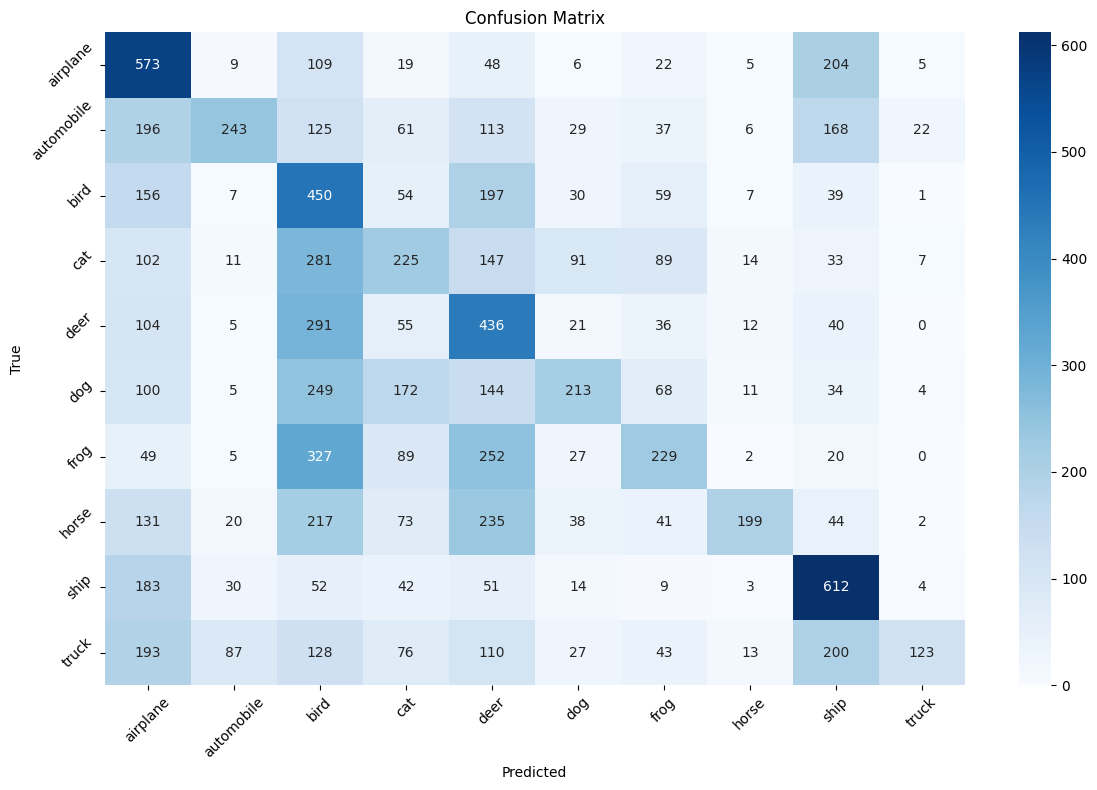

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix using seaborn.
    
    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    class_names: List of class names for labels
    """
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure and axes
    plt.figure(figsize=(12, 8))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer format
                cmap='Blues',  # Blue color scheme
                xticklabels=class_names,
                yticklabels=class_names)
    
    # Add labels
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    # Rotate x-labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_labels, predictions, class_names)


Top Correlated Class Pairs:
cat         dog      0.756912
bird        ship     0.741954
            deer     0.604652
deer        ship     0.579838
airplane    deer     0.532306
bird        frog     0.508749
airplane    cat      0.495423
            bird     0.492708
frog        ship     0.469660
airplane    frog     0.459721
automobile  bird     0.430275
cat         ship     0.416339
automobile  truck    0.363263
bird        truck    0.347926
airplane    dog      0.343497
dtype: float64

Condition number of correlation matrix: 5.597687464669568e+16


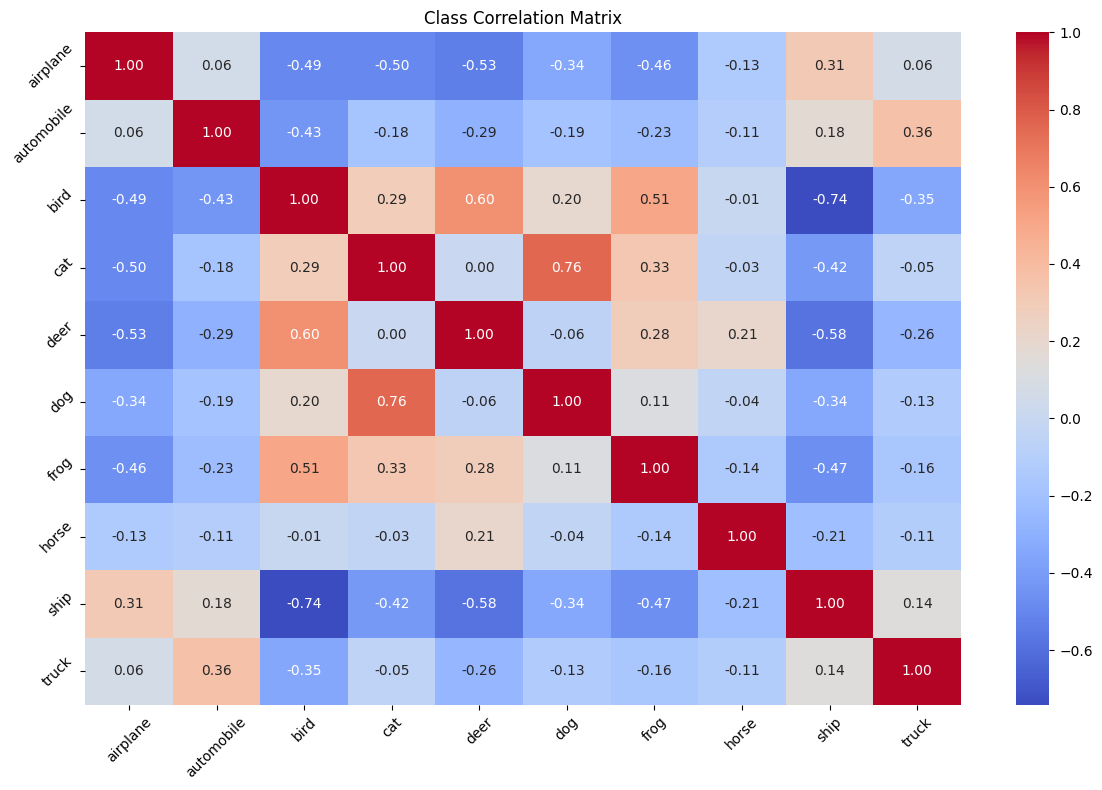

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(test_labels, predictions)

df = pd.DataFrame(cm, columns=class_names, index=class_names)

# Calculate correlation matrix
corr_matrix = df.corr()
abs_corr_matrix = corr_matrix.abs()

# Get correlation pairs
corr_pairs = abs_corr_matrix.unstack().drop_duplicates()
sorted_pairs = corr_pairs.sort_values(ascending=False)
sorted_pairs = sorted_pairs[sorted_pairs != 1]  # Remove self-correlations

print("Top Correlated Class Pairs:")
print(sorted_pairs.iloc[0:15])  # Top 15 correlations

print("\nCondition number of correlation matrix:", 
     np.linalg.cond(corr_matrix))

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
           annot=True, 
           fmt='.2f', 
           cmap='coolwarm',
           xticklabels=class_names,
           yticklabels=class_names)

plt.title('Class Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

**K Nearest Neighbors Model**

In [59]:


train_images = train_images.reshape(train_images.shape[0], -1)  
test_images = test_images.reshape(test_images.shape[0], -1) 
pca = PCA(n_components=100) 
train_images_pca = pca.fit_transform(train_images)
test_images_pca = pca.transform(test_images)


k_values = [1, 3]

results = []

for k in k_values:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Train the model
    knn.fit(train_images, train_labels)
    
    # Predict on the test set
    predictions = knn.predict(test_images)
    
    # Evaluate the accuracy
    accuracy = accuracy_score(test_labels, predictions)
    results.append((k, accuracy))

for k, accuracy in results:
    print(f'k = {k}, Accuracy = {accuracy * 100:.2f}%')

c:\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


k = 1, Accuracy = 35.39%
k = 3, Accuracy = 33.03%


**Nearest Local Centroid**

**Convolutional Neural Network Model**

In [60]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [63]:
# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = data_set.load_data()

# Normalize input between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0


In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3603 - loss: 1.7365 - val_accuracy: 0.5334 - val_loss: 1.3004
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5737 - loss: 1.1920 - val_accuracy: 0.6018 - val_loss: 1.1222
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6448 - loss: 1.0140 - val_accuracy: 0.6601 - val_loss: 0.9838
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6788 - loss: 0.9170 - val_accuracy: 0.6779 - val_loss: 0.9221
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7076 - loss: 0.8242 - val_accuracy: 0.6935 - val_loss: 0.8875
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7371 - loss: 0.7488 - val_accuracy: 0.7127 - val_loss: 0.8565
Epoch 7/10
 303/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7660 - loss: 0.6797

KeyboardInterrupt: 

313/313 - 7s - 22ms/step - accuracy: 0.7054 - loss: 0.8710
0.7053999900817871


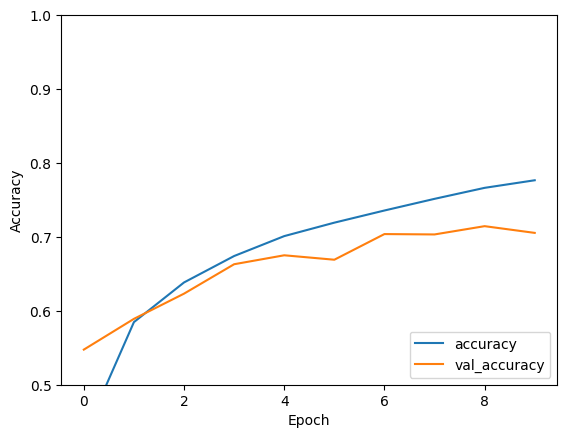

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

Plot Comparison - 3 Models

In [ ]:
#Error Vs Epoch
plt.plot(np.arange(1, logmodel.epochs + 1), logmodel.errors)  
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.show()

AttributeError: 'MultiClassLogisticRegression' object has no attribute 'errors'

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
#Confusion Matrices
predictions = logmodel.predict(X_test)
true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [ ]:
#F1 Score, Precision, Accuracy

**Conclusion**